## Description
Attached you find a randomly sampled extract of some of our policies.
We want to be able to predict the "number_of_payment_faults" 
(this is the number of payment attempts which failed when we try to charge the money for the policy from the customer) in the future for each new policy.
There is a small legend in the document to describe some of the fields.
If there are open questions about the data you can't answer by yourself do not hesitate to approach us!
Feel free to use whatever tool or language you feel comfortable with to solve the task.

## Task
Create a statistical model to predict the "number_of_payment_faults" for a policy.
There is no fixed or expected outcome what we want to see from you. 
We prefer quality over speed. 
It does not only matter if your solution yields correct results, but also your overall project structure, tools used, etc.


In [553]:
import collections

import math

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)

## 1. Load Data

In [554]:
df_friday = pd.read_excel('Your_Dataset.xlsx')

In [555]:
df_friday.shape

(27950, 18)

In [556]:
df_friday.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan


In [557]:
df_train = df_friday[df_friday['number_of_payment_faults'].notnull()]

In [558]:
df_test = df_friday[df_friday['number_of_payment_faults'].isnull()]

In [559]:
df_train.shape

(4789, 18)

In [560]:
df_test.shape

(23161, 18)

In [561]:
df_train.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
33,34,SF5,SF5,47,YOB,Original,New Vehicle,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,8,9,9000,8.000,1.000
35,36,SF1/2,SF1/2,37,YOB,Original,First Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,15,16,6000,5.000,2.000
38,39,SF1/2,SF1/2,42,YOB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,1,2,15000,1.000,2.000
47,48,SF23,SF3,63,YEB,Pay per km,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,4,5,12000,5.000,1.000


In [562]:
df_test.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan
5,6,SF7,SF13,37,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,0,15000,7.000,nan


In [563]:
df_train[df_train['number_of_payment_faults'].isnull()].shape

(0, 18)

## 2. EDA and Data Processing

In [564]:
df_friday.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,comprehensive_product,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,NaN,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000
1,2,SF31,SF31,55,YOB,Original,Change of Insurer,NaN,0,0,Pay In Full,Insured and Spouse/Partner,Standard,2,7,9000,6.000,nan
2,3,SF5,SF5,52,YOB,Original,New Vehicle,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,11,12,20000,1.000,nan
3,4,SF15,SF15,41,YEB,Original,Change of Insurer,TK,0,150,Monthly,Insured and Spouse/Partner,Standard,0,9,15000,6.000,nan
4,5,SF17,SF18,42,YOB,Original,Change of Insurer,VK,300,150,Monthly,Insured and Spouse/Partner,Standard,0,2,15000,3.000,nan


In [565]:
df_friday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27950 entries, 0 to 27949
Data columns (total 18 columns):
contract_nr                 27950 non-null int64
sf_class_tpl                27950 non-null object
sf_class_fc                 27950 non-null object
age_insured_person          27950 non-null int64
policy_start                27940 non-null object
tariff_type                 27950 non-null object
type_of_insurance           27950 non-null object
comprehensive_product       20355 non-null object
fc_deductible               27950 non-null int64
pc_deductible               27950 non-null int64
payment_interval            27950 non-null object
insured_parties             27950 non-null object
profession_group            27950 non-null object
car_age_at_purchase         27950 non-null int64
car_age_contract_start      27950 non-null int64
annual_mileage              27950 non-null int64
risk_predictor_zip_code     27948 non-null float64
number_of_payment_faults    4789 non-null float

In [566]:
df_friday.shape

(27950, 18)

- ### Missing Data

#### Check percentage of missing data

If more than 50% of the data is missing, we should delete the corresponding variable and pretend it never existed. 

In [567]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
comprehensive_product,2352,0.965
policy_start,3,0.001
risk_predictor_zip_code,1,0.000
number_of_payment_faults,0,0.000
sf_class_tpl,0,0.000
sf_class_fc,0,0.000
age_insured_person,0,0.000
tariff_type,0,0.000
type_of_insurance,0,0.000
fc_deductible,0,0.000


Text(0.5, 1.0, 'Percent missing data by feature')

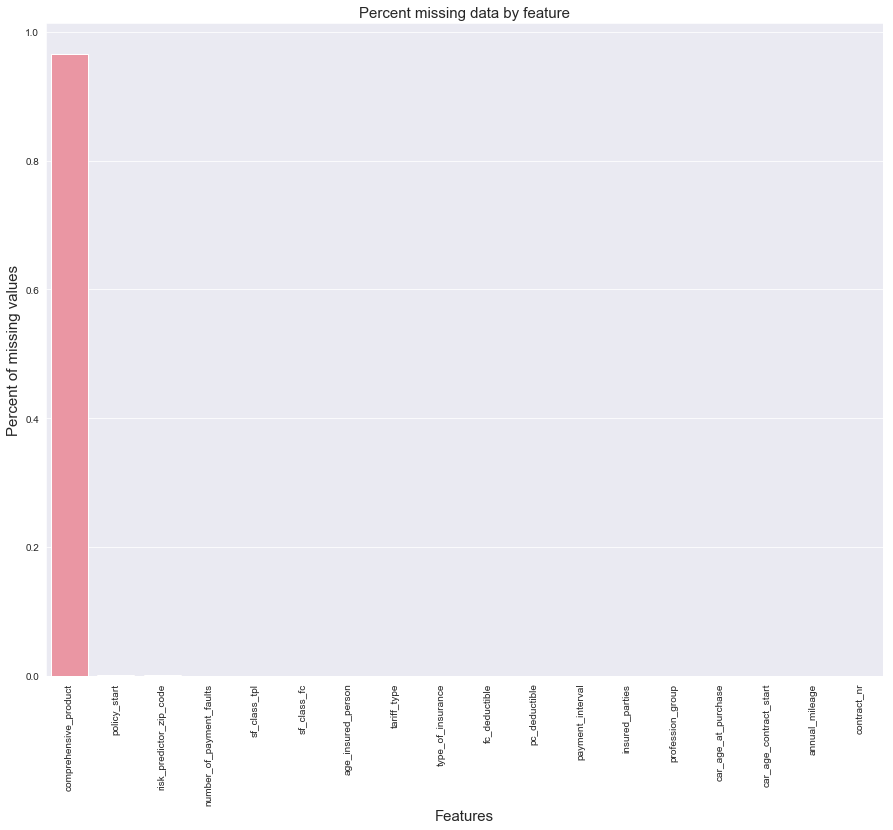

In [568]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=percent.index, y=percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [569]:
#Since most of the observations don't have information of 'comprehensive_product', I delete this field.
df_train.drop('comprehensive_product', axis=1, inplace=True)
df_test.drop('comprehensive_product', axis=1, inplace=True)

In [570]:
# handle the missing values: 
# - create a col_NA column to indicate which row has NAs.
def add_col_na(df_train, target):
    for col in df_train.columns:
        if col != target and is_numeric_dtype(df_train[col]):
            col_vals = df_train[col]
            if sum(col_vals.isnull()) != 0:
                df_train[col+'_na'] = col_vals.isnull()
                df_test[col+'_na'] = df_test[col].isnull()                
    return df_train, df_test

df_train, df_test = add_col_na(df_train, 'number_of_payment_faults')

In [571]:
df_train.head()

,contract_nr,sf_class_tpl,sf_class_fc,age_insured_person,policy_start,tariff_type,type_of_insurance,fc_deductible,pc_deductible,payment_interval,insured_parties,profession_group,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults,risk_predictor_zip_code_na
0,1,SF1/2,SF1/2,34,YOB,Original,New Vehicle,0,0,Monthly,Insured and Spouse/Partner,Standard,10,11,12000,5.000,1.000,False
33,34,SF5,SF5,47,YOB,Original,New Vehicle,0,150,Monthly,Insured and Spouse/Partner,Standard,8,9,9000,8.000,1.000,False
35,36,SF1/2,SF1/2,37,YOB,Original,First Vehicle,0,0,Monthly,Insured and Spouse/Partner,Standard,15,16,6000,5.000,2.000,False
38,39,SF1/2,SF1/2,42,YOB,Original,Change of Insurer,0,150,Monthly,Insured and Spouse/Partner,Standard,1,2,15000,1.000,2.000,False
47,48,SF23,SF3,63,YEB,Pay per km,Change of Insurer,300,150,Monthly,Insured and Spouse/Partner,Standard,4,5,12000,5.000,1.000,False


### 'sf_class_tpl' 

In [572]:
df_train['sf_class_tpl'].describe()

count      4789
unique       47
top       SF1/2
freq       1805
Name: sf_class_tpl, dtype: object

In [573]:
df_train['sf_class_tpl'].unique()

array(['SF1/2', 'SF5', 'SF23', 'SF1', 'SF18', 'SF35', 'SF10', 'SF2',
       'SF17', 0, 'SF19', 'SF24', 'SF13', 'SF14', 'SF8', 'SF7', 'SF21',
       'SF3', 'SF4', 'SF15', 'SF22', 'SF9', 'SF12', 'M', 'SF27', 'SF6',
       'SF16', 'SF11', 'SF28', 'SF37', 'SF20', 'SF30', 'SF31', 'SF34',
       'SF26', 'SF25', 'SF33', 'SF39', 'SF32', 'SF36', 'SF29', 'SF44',
       'SF42', 'SF41', 'SF40', 'SF38', 'S'], dtype=object)

In [574]:
df_train[df_train['sf_class_tpl'].isnull()].shape

(0, 18)

### 'sf_class_fc'

In [575]:
df_train['sf_class_fc'].describe()

count      4789
unique       47
top       SF1/2
freq       1834
Name: sf_class_fc, dtype: object

In [576]:
df_train['sf_class_fc'].unique()

array(['SF1/2', 'SF5', 'SF3', 'SF1', 'SF18', 'SF35', 'SF10', 'SF2',
       'SF22', 0, 'SF19', 'SF24', 'SF25', 'SF16', 'SF15', 'SF14', 'SF8',
       'SF7', 'SF21', 'SF4', 'SF23', 'SF9', 'M', 'SF12', 'SF13', 'SF6',
       'SF27', 'SF17', 'SF11', 'SF28', 'SF37', 'SF30', 'SF33', 'SF31',
       'SF34', 'SF20', 'SF26', 'SF29', 'SF32', 'SF36', 'SF41', 'SF44',
       'SF42', 'S', 'SF39', 'SF40', 'SF38'], dtype=object)

In [577]:
df_train[df_train['sf_class_fc'].isnull()].shape

(0, 18)

### 'policy_start'

In [578]:
df_train['policy_start'].describe()

count     4786
unique       2
top        YOB
freq      3362
Name: policy_start, dtype: object

In [579]:
df_train['policy_start'].unique()

array(['YOB', 'YEB', nan], dtype=object)

In [580]:
df_train[df_train['policy_start'].isnull()].shape

(3, 18)

### 'tariff_type'

In [581]:
df_train['tariff_type'].describe()

count         4789
unique           2
top       Original
freq          3816
Name: tariff_type, dtype: object

In [582]:
df_train['tariff_type'].unique()

array(['Original', 'Pay per km'], dtype=object)

In [583]:
df_train[df_train['tariff_type'].isnull()].shape

(0, 18)

### 'type_of_insurance'

In [584]:
df_train['type_of_insurance'].describe()

count                  4789
unique                    3
top       Change of Insurer
freq                   2594
Name: type_of_insurance, dtype: object

In [585]:
df_train['type_of_insurance'].unique()

array(['New Vehicle', 'First Vehicle', 'Change of Insurer'], dtype=object)

In [586]:
df_train[df_train['type_of_insurance'].isnull()].shape

(0, 18)

### 'payment_interval'

In [587]:
df_train['payment_interval'].describe()

count        4789
unique          2
top       Monthly
freq         4722
Name: payment_interval, dtype: object

In [588]:
df_train['payment_interval'].unique()

array(['Monthly', 'Pay In Full'], dtype=object)

In [589]:
df_train[df_train['payment_interval'].isnull()].shape

(0, 18)

### 'insured_parties'

In [590]:
df_train['insured_parties'].describe()

count                           4789
unique                             2
top       Insured and Spouse/Partner
freq                            3951
Name: insured_parties, dtype: object

In [591]:
df_train['insured_parties'].unique()

array(['Insured and Spouse/Partner', 'Insured and Others'], dtype=object)

In [592]:
df_train[df_train['insured_parties'].isnull()].shape

(0, 18)

### 'profession_group'

In [593]:
df_train['profession_group'].describe()

count         4789
unique           2
top       Standard
freq          4369
Name: profession_group, dtype: object

In [594]:
df_train['profession_group'].unique()

array(['Standard', 'Public service'], dtype=object)

In [595]:
df_train[df_train['profession_group'].isnull()].shape

(0, 18)

### 'age_insured_person'

In [596]:
def report_numerical_variables(df_friday, var_name):
    print('-------------')
    print(var_name)
    print('\n')
    
    print(df_friday[var_name].describe())
    
    sns.distplot(df_friday[var_name])
    
    #skewness and kurtosis
    print("Skewness: %f" % df_friday[var_name].skew())

    df_friday[[var_name]].boxplot()
    pyplot.show()

    df_friday[[var_name]].hist()
    pyplot.show()

    print('mean: {} median: {}'.format(df_friday[var_name].mean(), df_friday[var_name].median()))

    df_friday[df_friday[var_name].isnull()].shape

    sns.distplot(df_friday[var_name], fit=norm)
    fig = plt.figure()

    # https://matplotlib.org/mpl-probscale/tutorial/closer_look_at_viz.html
    res = stats.probplot(df_friday[var_name], plot=plt)
    
    num_null = df_friday[df_friday[var_name].isnull()].shape[0]
    print('number of null rows: {}'.format(num_null))


-------------
age_insured_person


count   4789.000
mean      41.868
std       13.748
min       18.000
25%       31.000
50%       40.000
75%       51.000
max       91.000
Name: age_insured_person, dtype: float64
Skewness: 0.654636


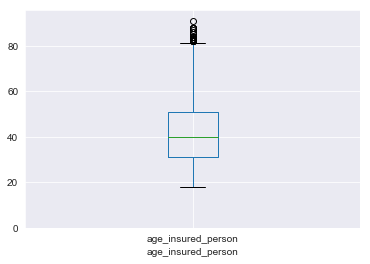

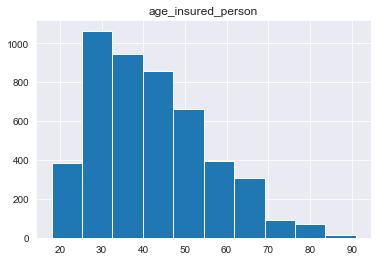

mean: 41.867822092294844 median: 40.0
number of null rows: 0


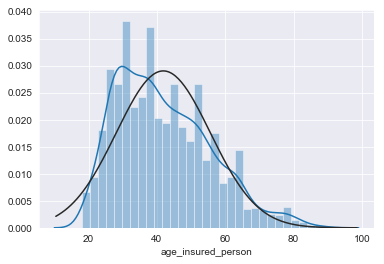

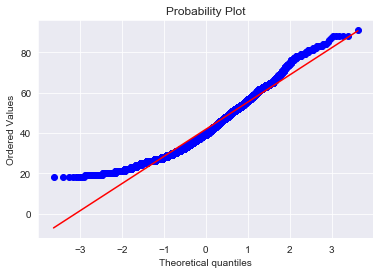

In [597]:
report_numerical_variables(df_train, 'age_insured_person')

### 'fc_deductible'

-------------
fc_deductible


count   4789.000
mean      91.334
std      179.384
min        0.000
25%        0.000
50%        0.000
75%        0.000
max     1000.000
Name: fc_deductible, dtype: float64
Skewness: 2.406833


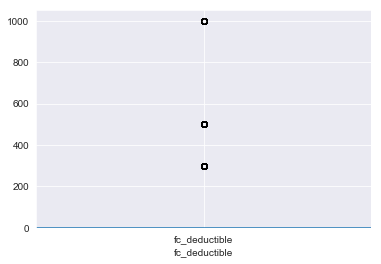

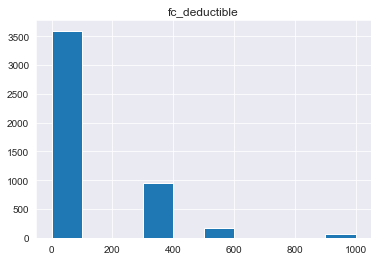

mean: 91.3343077886824 median: 0.0
number of null rows: 0


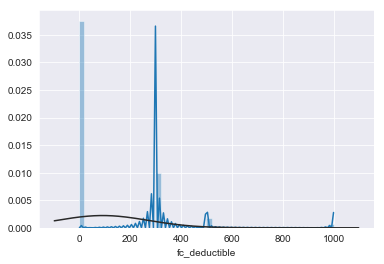

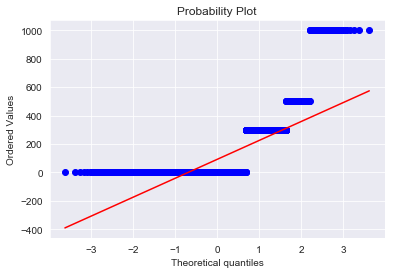

In [598]:
report_numerical_variables(df_train, 'fc_deductible')

### 'pc_deductible'

-------------
pc_deductible


count   4789.000
mean      85.519
std       93.411
min        0.000
25%        0.000
50%      150.000
75%      150.000
max      500.000
Name: pc_deductible, dtype: float64
Skewness: 0.897905


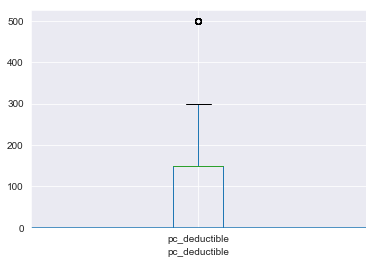

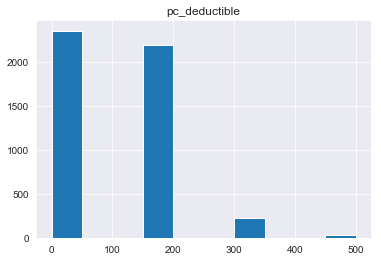

mean: 85.51889747337648 median: 150.0
number of null rows: 0


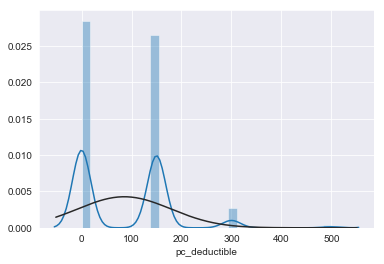

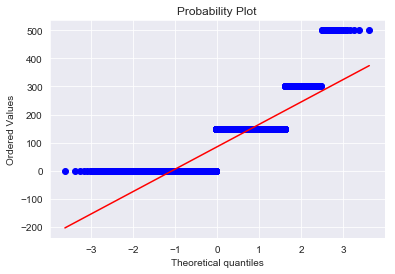

In [599]:
report_numerical_variables(df_train, 'pc_deductible')

### 'car_age_at_purchase'

-------------
car_age_at_purchase


count   4789.000
mean      10.342
std        7.086
min        0.000
25%        4.000
50%       11.000
75%       16.000
max       30.000
Name: car_age_at_purchase, dtype: float64
Skewness: -0.043320


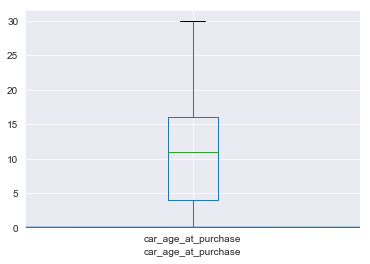

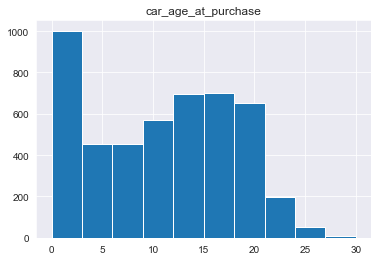

mean: 10.34245145124243 median: 11.0
number of null rows: 0


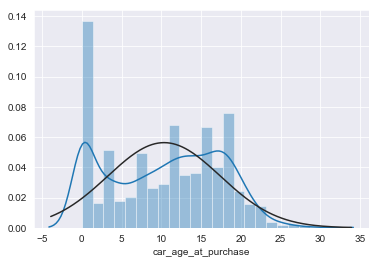

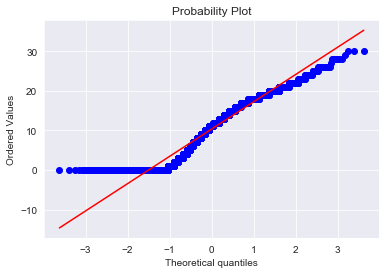

In [600]:
report_numerical_variables(df_train, 'car_age_at_purchase')

### 'car_age_contract_start'

-------------
car_age_contract_start


count   4789.000
mean      12.391
std        6.428
min        0.000
25%        8.000
50%       13.000
75%       18.000
max       31.000
Name: car_age_contract_start, dtype: float64
Skewness: -0.209361


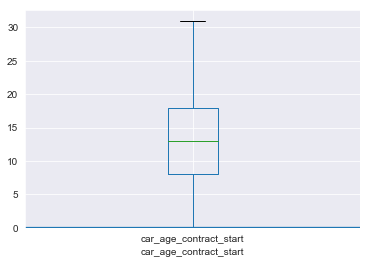

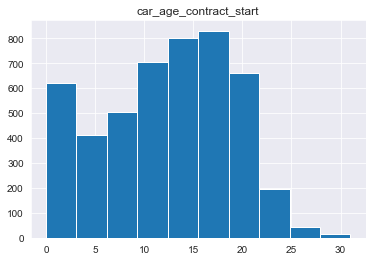

mean: 12.390895802881603 median: 13.0
number of null rows: 0


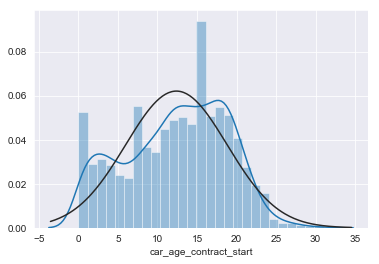

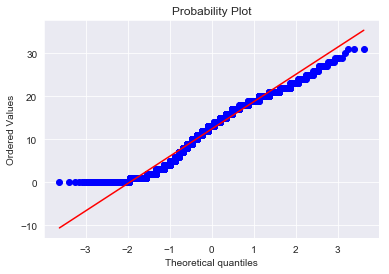

In [601]:
report_numerical_variables(df_train, 'car_age_contract_start')

### 'annual_mileage'

-------------
annual_mileage


count    4789.000
mean    12107.496
std      5734.010
min       600.000
25%      9000.000
50%     12000.000
75%     15000.000
max     90000.000
Name: annual_mileage, dtype: float64
Skewness: 1.791910


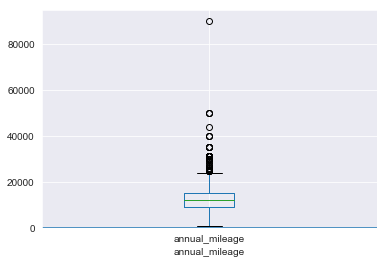

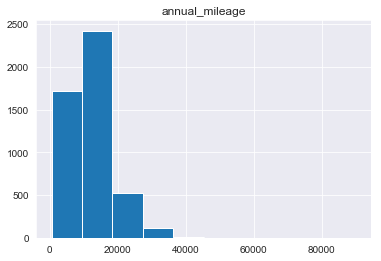

mean: 12107.49634579244 median: 12000.0
number of null rows: 0


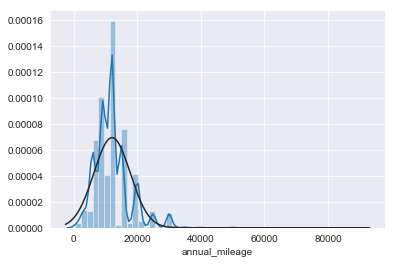

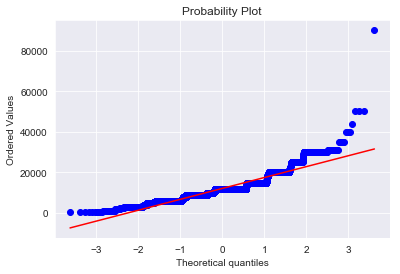

In [602]:
report_numerical_variables(df_train, 'annual_mileage')

### 'risk_predictor_zip_code'

In [603]:
df_train[df_train['risk_predictor_zip_code'].isnull()].shape

(1, 18)

In [604]:
df_train[df_train['risk_predictor_zip_code'].notnull()].shape

(4788, 18)

In [605]:
median_risk_pred_zip_code = df_train['risk_predictor_zip_code'].median()
median_risk_pred_zip_code

5.0

In [606]:
df_train['risk_predictor_zip_code'].fillna(median_risk_pred_zip_code, inplace=True)
df_test['risk_predictor_zip_code'].fillna(median_risk_pred_zip_code, inplace=True)

In [607]:
df_train['risk_predictor_zip_code'] = df_train['risk_predictor_zip_code'].apply(int)
df_test['risk_predictor_zip_code'] = df_test['risk_predictor_zip_code'].apply(int)

-------------
risk_predictor_zip_code


count   4789.000
mean       5.130
std        2.528
min        1.000
25%        3.000
50%        5.000
75%        7.000
max        9.000
Name: risk_predictor_zip_code, dtype: float64
Skewness: -0.047111


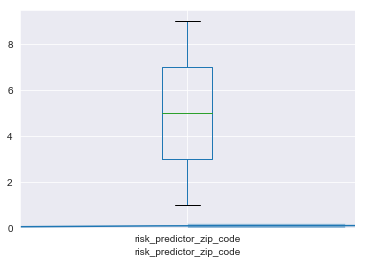

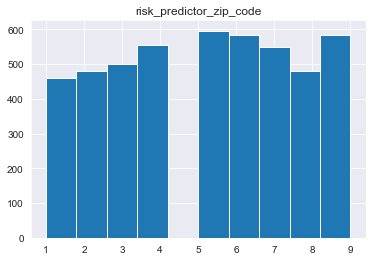

mean: 5.1302986009605345 median: 5.0
number of null rows: 0


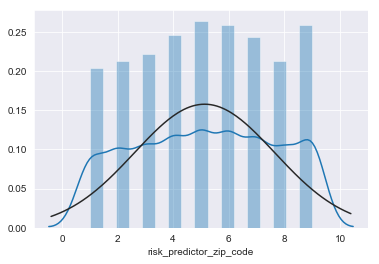

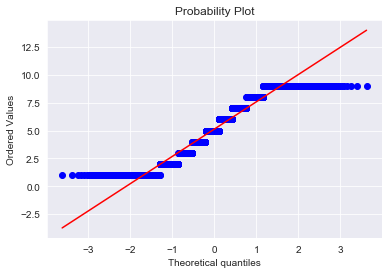

In [608]:
report_numerical_variables(df_train, 'risk_predictor_zip_code')

- ### Skewness


Transform the skewed numeric features by taking log(feature + 1). This will make the features more normal.

https://www.kaggle.com/humananalog/xgboost-lasso/code

Other approaches:

Box Cox Transformation of (highly) skewed features

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [609]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4789 entries, 0 to 27944
Data columns (total 18 columns):
contract_nr                   4789 non-null int64
sf_class_tpl                  4789 non-null object
sf_class_fc                   4789 non-null object
age_insured_person            4789 non-null int64
policy_start                  4786 non-null object
tariff_type                   4789 non-null object
type_of_insurance             4789 non-null object
fc_deductible                 4789 non-null int64
pc_deductible                 4789 non-null int64
payment_interval              4789 non-null object
insured_parties               4789 non-null object
profession_group              4789 non-null object
car_age_at_purchase           4789 non-null int64
car_age_contract_start        4789 non-null int64
annual_mileage                4789 non-null int64
risk_predictor_zip_code       4789 non-null int64
number_of_payment_faults      4789 non-null float64
risk_predictor_zip_code_na    47

In [610]:
numeric_features = ['fc_deductible', 'pc_deductible', 'car_age_at_purchase', 
                    'car_age_contract_start', 'annual_mileage', 'risk_predictor_zip_code'] 

In [611]:
skewed = df_train[numeric_features].apply(lambda x: skew(x.dropna().astype(int)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

df_train[skewed] = np.log1p(df_train[skewed])
df_test[skewed]  = np.log1p(df_test[skewed])

- ### Outliers

Some outliers could be removed, however outliers removal is note always safe. 
I decided not to delete any of the outliers, because I found there are many outliers in the dataset.
On the other hand, as indicated by https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
removing all outliers may affect badly the models if ever there were also outliers in the test data. That's why , instead of removing them all, we will just manage to make some of our models robust on them. 


- ### Scale numerical features

In [612]:
numeric_features = ['fc_deductible', 'pc_deductible', 'car_age_at_purchase', 
                    'car_age_contract_start', 'annual_mileage', 'risk_predictor_zip_code'] 

scaler = StandardScaler()
scaler.fit(df_train[numeric_features])

scaled = scaler.transform(df_train[numeric_features])
for i, col in enumerate(numeric_features):
    df_train[col] = scaled[:, i]
    
scaled = scaler.transform(df_test[numeric_features])
for i, col in enumerate(numeric_features):
    df_test[col] = scaled[:, i]


- ### One-hot encode categorical features


In [613]:
categorical_features = ['sf_class_tpl', 'sf_class_fc', 'policy_start', 'tariff_type', 'type_of_insurance', 
                        'payment_interval', 'insured_parties', 'profession_group'] 

In [614]:
#http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
#https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
dataset = pd.concat(objs=[df_train, df_test], axis=0)

for categorical_feature in categorical_features:
    dataset = pd.concat([dataset, 
                         pd.get_dummies(dataset[categorical_feature], prefix=categorical_feature, dummy_na=True)], 
                        axis=1)
    
    # now drop the original 'country' column (you don't need it anymore)
    dataset.drop([categorical_feature], axis=1, inplace=True)

train_len = len(df_train)
df_train = dataset[:train_len]
df_test = dataset[train_len:]

In [615]:
print(df_train.columns)

Index(['contract_nr', 'age_insured_person', 'fc_deductible', 'pc_deductible',
       'car_age_at_purchase', 'car_age_contract_start', 'annual_mileage',
       'risk_predictor_zip_code', 'number_of_payment_faults',
       'risk_predictor_zip_code_na',
       ...
       'type_of_insurance_nan', 'payment_interval_Monthly',
       'payment_interval_Pay In Full', 'payment_interval_nan',
       'insured_parties_Insured and Others',
       'insured_parties_Insured and Spouse/Partner', 'insured_parties_nan',
       'profession_group_Public service', 'profession_group_Standard',
       'profession_group_nan'],
      dtype='object', length=127)


- ### Convert boolean features to integer
We could also convert boolean features with one-hot encoding, if we want to us linear regression, neural networks, svm as regressors.

In [617]:
df_train.head()

,contract_nr,age_insured_person,fc_deductible,pc_deductible,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults,risk_predictor_zip_code_na,...,type_of_insurance_nan,payment_interval_Monthly,payment_interval_Pay In Full,payment_interval_nan,insured_parties_Insured and Others,insured_parties_Insured and Spouse/Partner,insured_parties_nan,profession_group_Public service,profession_group_Standard,profession_group_nan
0,1,34,-0.574,-1.016,-0.048,-0.216,0.204,-0.052,1.000,False,...,0,1,0,0,0,1,0,0,1,0
33,34,47,-0.574,0.950,-0.331,-0.528,-0.380,1.135,1.000,False,...,0,1,0,0,0,1,0,0,1,0
35,36,37,-0.574,-1.016,0.657,0.562,-1.203,-0.052,2.000,False,...,0,1,0,0,0,1,0,0,1,0
38,39,42,-0.574,0.950,-1.319,-1.617,0.657,-1.634,2.000,False,...,0,1,0,0,0,1,0,0,1,0
47,48,63,1.680,0.950,-0.895,-1.150,0.204,-0.052,1.000,False,...,0,1,0,0,0,1,0,0,1,0


In [618]:
bool_feature_columns = df_train.dtypes[df_train.dtypes == "bool"].index
bool_feature_columns.values

print(bool_feature_columns)

Index(['risk_predictor_zip_code_na'], dtype='object')


In [619]:
for bool_feature_col in bool_feature_columns:
    df_train[bool_feature_col] = df_train[bool_feature_col].astype('int32')
    df_test[bool_feature_col] = df_test[bool_feature_col].astype('int32')

In [620]:
df_train.head()

,contract_nr,age_insured_person,fc_deductible,pc_deductible,car_age_at_purchase,car_age_contract_start,annual_mileage,risk_predictor_zip_code,number_of_payment_faults,risk_predictor_zip_code_na,...,type_of_insurance_nan,payment_interval_Monthly,payment_interval_Pay In Full,payment_interval_nan,insured_parties_Insured and Others,insured_parties_Insured and Spouse/Partner,insured_parties_nan,profession_group_Public service,profession_group_Standard,profession_group_nan
0,1,34,-0.574,-1.016,-0.048,-0.216,0.204,-0.052,1.000,0,...,0,1,0,0,0,1,0,0,1,0
33,34,47,-0.574,0.950,-0.331,-0.528,-0.380,1.135,1.000,0,...,0,1,0,0,0,1,0,0,1,0
35,36,37,-0.574,-1.016,0.657,0.562,-1.203,-0.052,2.000,0,...,0,1,0,0,0,1,0,0,1,0
38,39,42,-0.574,0.950,-1.319,-1.617,0.657,-1.634,2.000,0,...,0,1,0,0,0,1,0,0,1,0
47,48,63,1.680,0.950,-0.895,-1.150,0.204,-0.052,1.000,0,...,0,1,0,0,0,1,0,0,1,0


- ### Log-transformation of the target variable

As (linear) models work well on normally distributed data, we need to transform the variable and make it more normally distributed.

In [622]:
# https://www.kaggle.com/humananalog/xgboost-lasso/code
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

df_train['number_of_payment_faults'] = df_train['number_of_payment_faults'].astype('int32')

df_target = pd.DataFrame(index = df_train.index, columns=['number_of_payment_faults'])
df_target['number_of_payment_faults'] = np.log1p(df_train['number_of_payment_faults'])